# Machine Learning: Build Predictive Models In Celonis With Process Mining Data
Celosphere, _15.04.2021_

Presenters:
- __Simon Brand__
- __Simon Klotz__

The ML Workbench is the central place to run machine learning algorithms or any other custom algorithm written in Python on your data. In this session we will show you step by step how to implement a Machine Learning use case. In more detail, we will cover how to load data into the Workbench, apply a machine learning algorithm to detect anomalies, and then push the data back to the data model.

<p style="color:red"><b>Disclaimer</b>:
This notebook is outdated and was only intended as a showcase to present the most commonly used features of PyCelonis.
It does not server as an out-of-the-box use case!</p>

## 1. Import required modules 
First we import the required Python modules. Any Python modules can be installed in the ML Workbench.

In [1]:
import os

from pycelonis import get_celonis
from pycelonis import pql as pql

import pandas as pd
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

## 2. Connect to Celonis

In [2]:
c = get_celonis()

2021-04-15 11:08:33 - pycelonis: Login successful! The Application Key currently has access to 0 Analyses and to 104 Data Pools.


### 2.1 Get Datamodel

In [3]:
data_model = c.datamodels.find("datamodel-name")
data_model

<Datamodel, id ec728ad0-e19f-4908-885f-be29670ce424, name celosphere21>

### 2.2 Get Knowledge Model
PyCelonis supports Studio components including the Knowledge Model which we use to retrieve required PQL queries.

In [4]:
studio_package = c.packages.find("package-name")
knowledge_model = studio_package.knowledge_models.find("knowledge-model-name")
knowledge_model

<KnowledgeModel, id 3f9d88ae-a7e3-4bcb-9a3c-3914e40aae8d, name celosphere-knowledge-model>

## 3. Load Data into Workbench
To load the data into the workbench we first build a query with the columns we want to get. We can use PQL strings or KPIs and Records from the knowledge model, as well as PQLFilters.

### 3.1 Build PQL Query

In [5]:
q = pql.PQL()

# Add columns
q += knowledge_model.records.find("CUSTOMER")
q += knowledge_model.kpis.find("NUMBER_OF_ORDERS")
q += pql.PQLColumn(""" ROUND_HOUR(PU_FIRST(VBAP, _CEL_O2C_ACTIVITIES.EVENTTIME)) """, "Timestamp")

# Add filter
q += pql.PQLFilter(""" DAYS_BETWEEN(ROUND_DAY(PU_FIRST(VBAP, _CEL_O2C_ACTIVITIES.EVENTTIME)), TODAY()) < 140 """)
q.query

['FILTER  DAYS_BETWEEN(ROUND_DAY(PU_FIRST(VBAP, _CEL_O2C_ACTIVITIES.EVENTTIME)), TODAY()) < 140 ;',
 'TABLE( "KNB1"."PERNR" AS "PERNR", "KNB1"."KUNNR" AS "KUNNR", COUNT_TABLE(VBAP) AS "NUMBER_OF_ORDERS",  ROUND_HOUR(PU_FIRST(VBAP, _CEL_O2C_ACTIVITIES.EVENTTIME))  AS "Timestamp" ) NOLIMIT;']

### 3.2 Load Data from Datamodel
After building a query we can execute it on the datamodel to get the data:

In [6]:
df = data_model.get_data_frame(q)

# Basic preprocessing
df = df.sort_values(["KUNNR", "Timestamp"])
df = df.set_index(["KUNNR", "Timestamp"])
df.head()

PERNR  NUMBER_OF_ORDERS
KUNNR      Timestamp                                      
0000001001 2020-12-04 03:00:00  00000000                 1
           2020-12-07 07:00:00  00000000                 2
           2020-12-07 08:00:00  00000000                 4
           2020-12-07 10:00:00  00000000                 3
           2020-12-07 11:00:00  00000000                 3

## 4. Define Functions for Anomaly Detection using Seasonal Decomposition

We apply basic preprocessing and then a seasonal decomposition. Finally, we use the difference between our timeseries and the seasonal component as anomaly score:

[//]: 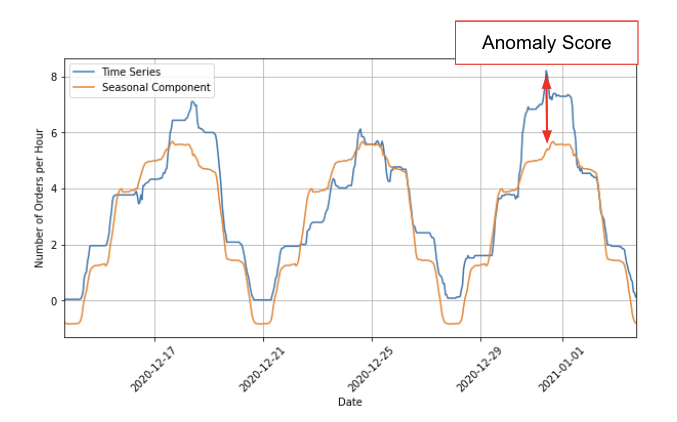

In [7]:
def clean_time_series(series, window=48):
    resampled_timeseries = series.resample("H").mean().fillna(0)
    cleaned_timeseries = resampled_timeseries.rolling(window).mean().iloc[window:]
    return cleaned_timeseries

In [8]:
from utils import plot_anomalies

def get_anomaly_indicators(cleaned_timeseries, upper_quantile=0.999, lower_quantile=0.01, plot=False):
    seasonal_component = seasonal_decompose(cleaned_timeseries, model='additive', period=24*7).seasonal
    anomaly_score = cleaned_timeseries - seasonal_component
    
    min_score, max_score = anomaly_score.quantile(lower_quantile), anomaly_score.quantile(upper_quantile)
    anomaly_indicators = (anomaly_score > max_score) | (anomaly_score < min_score)
    
    if plot:
        plot_anomalies(cleaned_timeseries, anomaly_indicators, anomaly_score, min_score, max_score)
    
    return anomaly_indicators

## 5. Run Anomaly Detection for all Customers
Now we run our algorithm for all customers separately.

In [9]:
result_dfs = []

for customer_id in tqdm(df.index.get_level_values('KUNNR').unique()):
    cleaned_timeseries = clean_time_series(df.loc[customer_id, "NUMBER_OF_ORDERS"])
    anomaly_indicators = get_anomaly_indicators(cleaned_timeseries, plot=False)

    customer_df = pd.DataFrame(anomaly_indicators, columns=["AnomalyIndicator"]).reset_index()
    customer_df["Customer"] = customer_id
    customer_df["NUMBER_OF_ORDERS"] = cleaned_timeseries.values
    
    result_dfs.append(customer_df)
    
result_df = pd.concat(result_dfs)
result_df.head()

  0%|          | 0/30 [00:00<?, ?it/s]

2021-04-15 11:08:36 - numexpr.utils: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-04-15 11:08:36 - numexpr.utils: NumExpr defaulting to 8 threads.


100%|██████████| 30/30 [00:00<00:00, 92.03it/s]


,Timestamp,AnomalyIndicator,Customer,NUMBER_OF_ORDERS
0,2020-12-06 03:00:00,False,0000001001,0.0
1,2020-12-06 04:00:00,False,0000001001,0.0
2,2020-12-06 05:00:00,False,0000001001,0.0
3,2020-12-06 06:00:00,False,0000001001,0.0
4,2020-12-06 07:00:00,False,0000001001,0.0


In [10]:
print("#Anomalies:", result_df.AnomalyIndicator.value_counts()[True])

#Anomalies: 1078


## 6. Examples

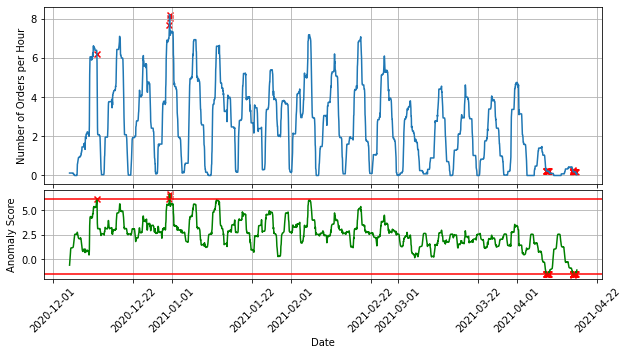

In [11]:
customer_id = "0000001360"
cleaned_timeseries = clean_time_series(df.loc[customer_id, "NUMBER_OF_ORDERS"])
anomaly_indicators = get_anomaly_indicators(cleaned_timeseries, plot=True)

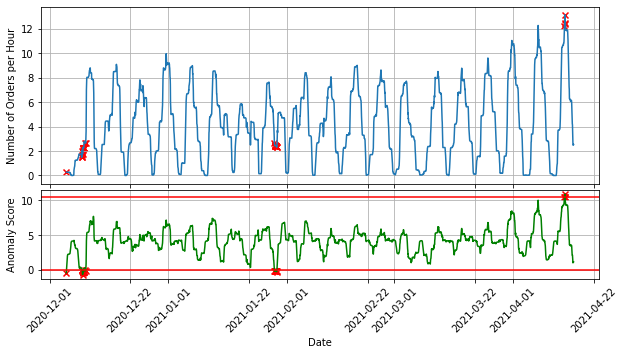

In [12]:
customer_id = "0000002004"
cleaned_timeseries = clean_time_series(df.loc[customer_id, "NUMBER_OF_ORDERS"])
anomaly_indicators = get_anomaly_indicators(cleaned_timeseries, plot=True)

## 7. Push Data back to Datamodel
Finally, we push the data back to the datamodel to be able to view it in Studio and other Celonis Services.

In [13]:
# Create new table or overwrite existing one
data_model.pool.create_table(
    df_or_path=result_df,
    table_name="AnomalyDetectionResults",
    if_exists='drop'
);

2021-04-15 11:08:41 - pycelonis: Dropping existing table AnomalyDetectionResults.
2021-04-15 11:08:42 - pycelonis: Data push job started...
2021-04-15 11:08:52 - pycelonis: Data push job status finished: DONE


In [14]:
try:
    data_model.add_table_from_pool(table_name="AnomalyDetectionResults")
except ValueError:
    pass # Table has already been added

In [ ]:
# Reload datamodel
data_model.reload(tables=["AnomalyDetectionResults"]);

2021-04-15 11:08:56 - pycelonis: Partial Data Model reload started...
